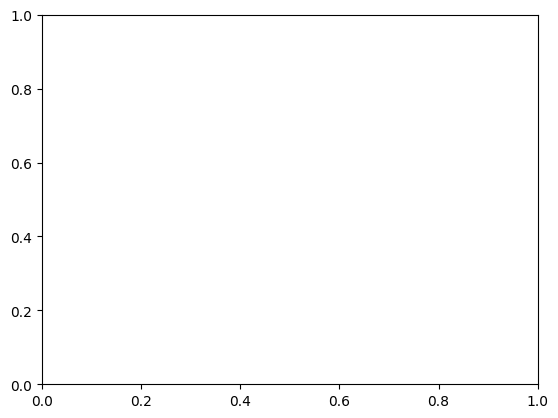

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# Game of Life setup
N = 10  # Size of the grid
ON = 255  # cells that are alive
OFF = 0  # cells that are dead
vals = [ON, OFF]

# populate grid with random on/off - more off than on
grid = np.random.choice(vals, N*N, p=[0.2, 0.8]).reshape(N, N)
# Correcting the code to define 'img' before using it in FuncAnimation

# # Initialize the plot with the initial grid state
# img = ax.imshow(grid, interpolation='nearest', cmap='gray_r')

# def update(frameNum, img, grid, N):
#     # copy grid since we require 8 neighbors for calculation
#     # and we go line by line 
#     newGrid = grid.copy()
#     for i in range(N):
#         for j in range(N):
#             # compute 8-neighbor sum using toroidal boundary conditions
#             total = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
#                          grid[(i-1)%N, j] + grid[(i+1)%N, j] +
#                          grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
#                          grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N])/255)
            
#             # apply Conway's rules
#             if grid[i, j]  == ON:
#                 if (total < 2) or (total > 3):
#                     newGrid[i, j] = OFF
#             else:
#                 if total == 3:
#                     newGrid[i, j] = ON

#     # update data
#     img.set_data(newGrid)
#     grid[:] = newGrid[:]
#     return img,

# # Set up the animation
# ani = FuncAnimation(fig, update, fargs=(img, grid, N),
#                     frames=100,
#                     interval=200,
#                     save_count=50)

# # To display the animation in a Jupyter notebook, we need to use HTML
# from IPython.display import HTML
# plt.close()  # Prevents the initial static plot from displaying

# # Convert the animation to HTML and display it in the notebook
# HTML(ani.to_jshtml())


In [34]:
import pandas as pd


# Function to evolve the grid by one step according to Conway's rules
def evolve_grid(grid, N):
    new_grid = grid.copy()
    for i in range(N):
        for j in range(N):
            total = int(
                (
                    grid[i, (j - 1) % N]
                    + grid[i, (j + 1) % N]
                    + grid[(i - 1) % N, j]
                    + grid[(i + 1) % N, j]
                    + grid[(i - 1) % N, (j - 1) % N]
                    + grid[(i - 1) % N, (j + 1) % N]
                    + grid[(i + 1) % N, (j - 1) % N]
                    + grid[(i + 1) % N, (j + 1) % N]
                )
                / 255
            )

            if grid[i, j] == ON:
                if (total < 2) or (total > 3):
                    new_grid[i, j] = OFF
            else:
                if total == 3:
                    new_grid[i, j] = ON
    return new_grid


# Generate data for training and testing
def generate_data(num_instances, grid_size, filename):
    data = []
    for init in [(0.2, 0.8), (0.5, 0.5), (0.7, 0.3)]:
        for _ in range(num_instances):
            initial_grid = np.random.choice(
                vals, grid_size * grid_size, p=list(init)
            ).reshape(grid_size, grid_size)
            subsequent_grid = evolve_grid(initial_grid, grid_size)
            # Flatten and concatenate the two states into one list
            instance = np.concatenate(
                (initial_grid.flatten(), subsequent_grid.flatten())
            )
            data.append(instance)

    # Convert the data into a pandas DataFrame and then save as CSV
    df = pd.DataFrame(data)
    df.to_csv(f"./gol/{filename}.csv", index=False, header=False)


# Set new grid size and generate training and testing data
num_train_instances = 5000
num_test_instances = 1000

# Generate and save training data
generate_data(num_train_instances, N, "training_data")

# Generate and save testing data
generate_data(num_test_instances, N, "testing_data")

# Return the paths to the saved CSV files
training_data_path = "./gol/training_data.csv"
testing_data_path = "./gol/testing_data.csv"

(training_data_path, testing_data_path)

('./gol/training_data.csv', './gol/testing_data.csv')

In [35]:
# Function to load CSV data and transform it
def load_and_transform_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, header=None).values
    # Transform the data: change 255 to 1
    data[data == 255] = 1
    return data

# Load and transform the training data as an example
train = load_and_transform_data('./gol/training_data.csv')
test = load_and_transform_data('./gol/testing_data.csv')

In [36]:
from sklearn.model_selection import train_test_split

x_train = train[:, : N * N]
y_train = train[:, N * N :]
x_test = train[:, : N * N]
y_test = train[:, N * N :]

In [37]:
x_train.shape

(15000, 100)

In [55]:
import tensorflow as tf
from tensorflow import keras

with tf.device("/GPU:0"):  # Use '/CPU:0' to force it to run on CPU
    num_cells = N * N

    model = keras.models.Sequential()
    model.add(keras.layers.Reshape((N, N, 1), input_shape=(num_cells,)))  # Reshape input to be 20x20x1
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # Convolutional layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # Convolutional layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # Convolutional layer
    model.add(keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'))  # Output layer
    model.add(keras.layers.Reshape((num_cells,)))  # Flatten the output to match Y shape
    # model.add(
    #     keras.layers.InputLayer(input_shape=(num_cells,))
    # )  # Define the input shape
    # model.add(
    #     keras.layers.Dense(num_cells, activation="relu")
    # )  # First layer with ReLU activation
    # model.add(
    #     keras.layers.Dense(num_cells, activation="sigmoid")
    # )  # Output layer with sigmoid activation

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy()
        ],  # Use BinaryAccuracy for binary classification
    )

    # Assuming x_train, y_train, x_test, and y_test are defined and correctly shaped
    model_history = model.fit(
        x_train,
        y_train,
        batch_size=200,
        epochs=100,
        verbose=1,
        validation_data=(x_test, y_test),
    )

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=2)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

    print(f"Training accuracy: {train_accuracy}, Testing accuracy: {test_accuracy}")

Epoch 1/100
75/75 [==============================] - 1s 9ms/step - loss: 0.4379 - binary_accuracy: 0.8231 - val_loss: 0.3644 - val_binary_accuracy: 0.8236
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 0.3160 - binary_accuracy: 0.8514 - val_loss: 0.2626 - val_binary_accuracy: 0.8962
Epoch 3/100
75/75 [==============================] - 1s 7ms/step - loss: 0.2448 - binary_accuracy: 0.8944 - val_loss: 0.2023 - val_binary_accuracy: 0.9253
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 0.2048 - binary_accuracy: 0.9190 - val_loss: 0.2949 - val_binary_accuracy: 0.8730
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.1843 - binary_accuracy: 0.9255 - val_loss: 0.1590 - val_binary_accuracy: 0.9376
Epoch 6/100
75/75 [==============================] - 1s 8ms/step - loss: 0.1755 - binary_accuracy: 0.9273 - val_loss: 0.1521 - val_binary_accuracy: 0.9388
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - los

KeyboardInterrupt: 